In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

# Load data

In [2]:
import pickle

# # Specify the file name
file_name = '../Chandra_data/large_eventfiles_filtered_lifetime28800_latents.pkl'

# # Load and deserialize the list from the file
# with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
#     pickle.dump(collated_outputs, file)
    
with open(file_name, 'rb') as file: 
    collated_outputs = pickle.load(file)

In [3]:
collated_outputs.keys()

dict_keys(['id', 'event_list', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h', 'event_list_len', 'idx', 'mask', 'latent', 'rates', 'total_rates', 'total_list', 'T', 'num_events', 'total_mask', 'num_events_per'])

In [4]:
data = {}
for key in ['latent', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']:
    data[key] = collated_outputs[key].numpy()

## Regression on hard_hm

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

y_label = 'hard_ms'

# Prepare your data: separate features (X) and the target variable (y)
X = data['latent']
y = data[y_label]
y[np.isnan(y)]=0

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Model MSE: {mse:.2f}")
print(f"Model R-squared: {r2:.2f}")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model MSE: {mse:.2f}")
print(f"Model R-squared: {r2:.2f}")

Model MSE: 0.00
Model R-squared: 0.99
Model MSE: 0.02
Model R-squared: 0.89


In [36]:
y_label = 'var_prob_s'

# Prepare your data: separate features (X) and the target variable (y)
X = data['latent']
y = data[y_label]
valid_ind = ~np.isnan(y)
X = X[valid_ind,:]
y = y[valid_ind]

valid_ind = (y<1)
X = X[valid_ind,:]
y = y[valid_ind]

y = np.log(y/(1-y))

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Model MSE: {mse:.2f}")
print(f"Model R-squared: {r2:.2f}")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model MSE: {mse:.2f}")
print(f"Model R-squared: {r2:.2f}")

Model MSE: 0.90
Model R-squared: 0.91
Model MSE: 6.17
Model R-squared: 0.38


## Classification on variability index

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

y_label = 'var_index_b'

# Prepare your data: separate features (X) and the target variable (y)
X = data['latent']
y = data[y_label]
valid_ind = ~np.isnan(y)
X = X[valid_ind,:]
y = y[valid_ind]
y = 1 * (y >= 6)


# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
classification_rep = classification_report(y_train, y_train_pred)

print(f"Model accuracy: {accuracy:.2f}")
print("Classification report:")
print(classification_rep)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Evaluate the model using accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Model accuracy: {accuracy:.2f}")
print("Classification report:")
print(classification_rep)

Model accuracy: 1.00
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10688
           1       1.00      1.00      1.00      1224

    accuracy                           1.00     11912
   macro avg       1.00      1.00      1.00     11912
weighted avg       1.00      1.00      1.00     11912

Model accuracy: 0.94
Classification report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2690
           1       0.95      0.42      0.59       289

    accuracy                           0.94      2979
   macro avg       0.95      0.71      0.78      2979
weighted avg       0.94      0.94      0.93      2979



## Classification on source type

In [5]:
# Read data
true_classes_df = pd.read_csv('../Chandra_data/TD.csv')
raw_property_df = pd.read_csv('../Chandra_data/properties-Full.csv')

In [9]:
raw_property_df = raw_property_df.drop_duplicates(subset=['name', 'obsid','region_id'])
len(raw_property_df)

129527

In [10]:
true_classes_df.head()

,CSCv2_name,CSCv2_RA,CSCv2_DEC,CSCv2_PU,CSCv2_S/N,Fs,e_Fs,Fm,e_Fm,Fh,...,e_P_NS,e_P_YSO,Class,Class_prob,e_Class_prob,CT,CSCv2_flags,Catalog_name,True_Class,Class_ref
0,2CXO J000009.3+135618,0.039115,13.938493,0.79,1.95,2.000000e-15,1.000000e-15,5.000000e-16,5.000000e-16,2.000000e-15,...,0.0040,0.0500,AGN,0.900,0.100,5.307,NaN,SDSS J00001+1356,AGN,2010A&A...518A..10V
1,2CXO J000230.7+004959,0.627974,0.833072,0.72,11.07,5.700000e-14,7.000000e-15,2.900000e-14,5.000000e-15,6.000000e-14,...,0.0003,0.0004,AGN,0.999,0.004,145.799,NaN,PB 5698,AGN,2010A&A...518A..10V
2,2CXO J000622.6-000424,1.594324,-0.073573,0.78,25.42,1.500000e-13,1.000000e-14,1.170000e-13,8.000000e-15,4.000000e-13,...,0.0050,0.0009,AGN,0.970,0.020,20.820,extent,3C 2.0,AGN,2010A&A...518A..10V
3,2CXO J000659.2-001740,1.747051,-0.294661,0.84,4.11,1.100000e-14,4.000000e-15,6.000000e-15,3.000000e-15,1.400000e-14,...,0.0030,0.0070,AGN,0.950,0.060,8.318,NaN,SDSS J00069-0017,AGN,2010A&A...518A..10V
4,2CXO J000703.6+155423,1.765007,15.906575,0.72,8.63,5.000000e-15,3.000000e-15,1.600000e-14,6.000000e-15,5.400000e-13,...,0.0004,0.0090,AGN,0.990,0.010,47.057,NaN,2MASS J00070+1554,AGN,2010A&A...518A..10V


In [11]:
raw_property_df.head()

,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,conf_flag,sat_src_flag,...,hard_hs_lolim,hard_hs_hilim,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b,var_index_w,livetime,detector
0,2CXO J000000.5-575830,0.002735,-57.975181,2.819565,1.667655,91.090421,8.522222,TRUE,True,False,...,-0.524047,-0.267958,0.085129,0.121377,0.376451,0.175421,0.0,NaN,30146.733203,ACIS-6
1,2CXO J000001.7+003824,0.007280,0.640146,1.093394,0.871849,104.849964,5.485207,TRUE,False,False,...,-0.145534,0.269207,0.612624,0.585561,0.519756,0.678199,1.0,NaN,23719.527217,ACIS-7
2,2CXO J000002.4+004444,0.010189,0.745732,0.746484,0.723548,34.468703,5.774224,TRUE,False,False,...,-0.400375,0.003123,0.425172,0.465109,0.489993,0.754087,0.0,NaN,23719.527217,ACIS-7
3,2CXO J000002.4+321750,0.010280,32.297465,1.067836,0.944977,115.769199,5.028571,TRUE,False,False,...,-0.497814,0.222986,0.154076,0.177304,0.548595,NaN,0.0,NaN,24735.257397,ACIS-3
4,2CXO J000002.9-350332,0.012314,-35.059185,0.855386,0.735828,172.590089,16.266113,TRUE,False,False,...,-0.502811,-0.377889,0.067012,0.113151,0.235485,0.080282,0.0,NaN,9937.243792,ACIS-6


In [12]:
matched_df = pd.merge(true_classes_df.rename(columns={'CSCv2_name': 'name'}), raw_property_df, on='name', how='inner')
matched_df = matched_df[['True_Class','region_id','obsid']]
matched_df['id'] = matched_df['obsid'].astype(str) + "_" + matched_df['region_id'].astype(str)
matched_d = {}
for _, row in matched_df.iterrows():
    matched_d[row['id']] = row['True_Class']
    
data = {'True_Class':[]}
temp_ids = collated_outputs['id']
collated_ids = [e for sublist in temp_ids for e in sublist]

final_matched_inds = []
for i,ind in enumerate(collated_ids):
    if ind[:-2] in matched_d.keys():
        final_matched_inds.append(i)
        data['True_Class'].append(matched_d[ind[:-2]])
data['latent'] = collated_outputs['latent'][final_matched_inds,:]

class_matching_d = {'AGN':0, 'CV':1, 'HM-STAR':2, 'HMXB':3, 'LM-STAR':4, 'LMXB':5, 'NS':6, 'YSO':7}
data['numbered_class'] = [class_matching_d[k] for k in data['True_Class']]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

y_label = 'numbered_class'

# Prepare your data: separate features (X) and the target variable (y)
X = data['latent']
y = data[y_label]

rs = 46
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)


# Create the Random Forest classifier model
model = RandomForestClassifier(n_estimators=100, random_state=rs)

# Train the model
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
classification_rep = classification_report(y_train, y_train_pred)

print(f"Model accuracy: {accuracy:.2f}")
print("Classification report:")
print(classification_rep)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Evaluate the model using accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Model accuracy: {accuracy:.2f}")
print("Classification report:")
print(classification_rep)

Model accuracy: 1.00
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        43
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00        47
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        54
           7       1.00      1.00      1.00       819

    accuracy                           1.00      1287
   macro avg       1.00      1.00      1.00      1287
weighted avg       1.00      1.00      1.00      1287

Model accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.39      0.49        69
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        10
           4       0.00      0.00      0.00 

/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

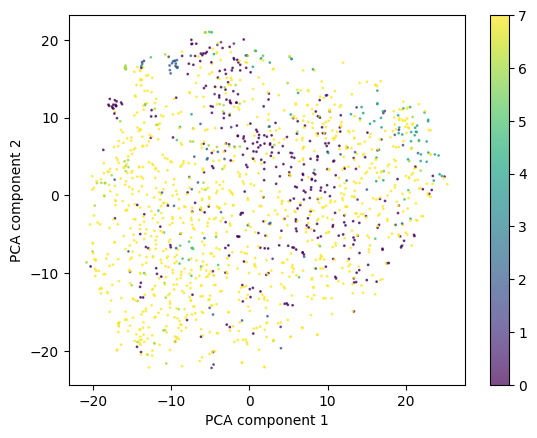

In [19]:
from sklearn.decomposition import PCA
from bhtsne import tsne
# pca = PCA(n_components=2)
# embedding = pca.fit_transform(X)

embedding = tsne(X.numpy().astype(np.float64))

plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', alpha=0.7, 
            marker='o',s=1, vmin=min(y), vmax=max(y))
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.colorbar()